In [1]:
%matplotlib inline
import math as m
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from SAMPEX_functions import read_counts as read
from SAMPEX_functions import mb_finder, read_days, mb_magnitude, iso_calculator, OrbAtt_augment_loop
import pandas as pd
import os
import pathlib
import string
import datetime

In [2]:
'1993335-1993340' == '1993335-1993340'

True

In [3]:
# defining files
storms = np.array(['1993047-1993053', '1993067-1993069', '1993070-1993071', '1993093-1993099', '1993127-1993133', '1993254-1993260', \
          '1993280-1993286', '1993306-1993312', '1993335-1993340'])

bad_storms = np.array(['1993127-1993133', '1993280-1993286', '1993335-1993340'])

for bad in bad_storms:
    storms = storms[storms != bad]

# reading in mag indices
# define mag indices data
directory = 'E:\SAMPEX_Data\\'
file = 'mag_indices_1993.txt'
mag_indices = pd.read_csv(directory + file, header = None, delimiter='\s+')

# define day, hr, min, AE, and Dst
ind_day = np.array(mag_indices[1])
ind_hr = np.array(mag_indices[2])
ind_min = np.array(mag_indices[3])

AE = np.array(mag_indices[4])
Dst = np.array(mag_indices[5])

mag_indices = pd.read_csv(directory + file, header = None, delimiter='\s+')

# defining month
month_list = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# code is specific for year 1993
OrbAtt_names = np.array(['OrbAtt_secofyear_1993001-1993012.txt', 'OrbAtt_secofyear_1993013-1993039.txt', 'OrbAtt_secofyear_1993040-1993066.txt', \
                         'OrbAtt_secofyear_1993067-1993093.txt', 'OrbAtt_secofyear_1993094-1993120.txt', 'OrbAtt_secofyear_1993121-1993147.txt', \
                         'OrbAtt_secofyear_1993148-1993174.txt', 'OrbAtt_secofyear_1993175-1993201.txt', 'OrbAtt_secofyear_1993202-1993228.txt', \
                         'OrbAtt_secofyear_1993229-1993255.txt', 'OrbAtt_secofyear_1993256-1993282.txt', 'OrbAtt_secofyear_1993283-1993309.txt', \
                         'OrbAtt_secofyear_1993310-1993336.txt', 'OrbAtt_secofyear_1993337-1993363.txt', 'OrbAtt_secofyear_1993364-1993365.txt'])

In [4]:
iso_MB_prestorm_list = np.array([])
iso_MB_mainphase_list = np.array([])
iso_MB_recovery_list = np.array([])
iso_BG_prestorm_list = np.array([])
iso_BG_mainphase_list = np.array([])
iso_BG_recovery_list = np.array([])

for storm in storms:
    print(f'Extracting data from storm {storm} ...')
    # defining file
    year = int(storm[0:4])
    start_day = int(storm[4:7])
    end_day = int(storm[12:])
    num_days = end_day - start_day + 1
    
    iso_MB_list = np.array([])
    iso_BG_list = np.array([])
    t_MB_list = np.array([])
    t_BG_list = np.array([])
    for day_of_year in np.arange(start_day, end_day+1):
        # name the day
        if len(str(day_of_year)) == 1:
            file = 'hhrr' + str(year) + '00' + str(day_of_year) + '.txt'
        elif len(str(day_of_year)) == 2:
            file = 'hhrr' + str(year) + '0' + str(day_of_year) + '.txt'
        elif len(str(day_of_year)) == 3:
            file = 'hhrr' + str(year) + str(day_of_year) + '.txt'

        # reading in electron counts files:
        t_electrons, r1, r2, r3, r4 = read(str(year) + '_data\\' + file)

        # reading in orbit/attitude data file
        OrbAtt_mask = []
        for i in np.arange(len(OrbAtt_names)):
            OrbAtt_mask.append(day_of_year >= int(OrbAtt_names[i][21:24]) and day_of_year <= int(OrbAtt_names[i][29:32]))
        
        OA_file = OrbAtt_names[OrbAtt_mask][0]
    
        directory = 'E:\SAMPEX_Data\\' + str(year) + '_data\\'
        OrbAtt_file = pd.read_csv(directory + OA_file, names = ['day', 'hr', 'min', 'sec', 'GEO_Radius', 'GEO_Long', 'GEO_Lat', 'Altitude', 
                                                            'L_Shell', 'MLT', 'SAA_Flag', 'Pitch', 'zenith', 'azimuth', 'Att_Flag'], sep = '\s+', header = 70)
    
        # Augment OrbAtt data to fit counts data
        t_OrbAtt, LS_OrbAtt, MLT_OrbAtt, P_OrbAtt, Lat_OrbAtt, Long_OrbAtt, R_OrbAtt, t_electrons, r1, r2, r3, r4 = OrbAtt_augment_loop(t_electrons, r1, r2, r3, r4, OrbAtt_file, day_of_year)


        ############## mask for spatial/temporal regions ##############
        
        mask = (np.abs(90 - P_OrbAtt) >= 50) & (LS_OrbAtt >= 3) & (LS_OrbAtt <= 8)
        t_OrbAtt = t_OrbAtt[mask]; LS_OrbAtt = LS_OrbAtt[mask]; MLT_OrbAtt = MLT_OrbAtt[mask];
        P_OrbAtt = P_OrbAtt[mask]; Lat_OrbAtt = Lat_OrbAtt[mask]; Long_OrbAtt = Long_OrbAtt[mask];
        R_OrbAtt = R_OrbAtt[mask]; t_electrons = t_electrons[mask]; r1 = r1[mask]; r2 = r2[mask]; r3 = r3[mask]; r4 = r4[mask]

        ###############################################################
    
    
        # find microburst times and N_100, SSD1, SSD4 counts using algorithm
        t_microburst, N_100_microburst, r1_microburst, r4_microburst, mb_index, MB_mask, N_100, A_500 = mb_finder(t_electrons, r1, r2, r3, r4)

        # create background counts mask
        BG_mask = ~MB_mask

        # calculation of the isotropy indices of electron counts
        iso_indices_MB = iso_calculator(r1[MB_mask], r4[MB_mask])
        iso_indices_BG = iso_calculator(r1[BG_mask], r4[BG_mask])
    
        # find the OrbAtt and magnetic index microburst and backgound parameters
        if len(mb_index) > 0:
            t_OrbAtt_MB = t_OrbAtt[mb_index]
            t_MB = t_OrbAtt_MB + day_of_year*3600*24
            t_MB_list = np.append(t_MB_list, t_MB)
            iso_MB_list = np.append(iso_MB_list, iso_indices_MB)
        
        t_OrbAtt_BG = t_OrbAtt[BG_mask]
        t_BG = t_OrbAtt_BG + day_of_year*3600*24
        t_BG_list = np.append(t_BG_list, t_BG)
        iso_BG_list = np.append(iso_BG_list, iso_indices_BG)
    
    # mask indices for correct storm time period
    AE_storm = AE[(ind_day >= start_day) & (ind_day <= end_day)]
    Dst_storm = Dst[(ind_day >= start_day) & (ind_day <= end_day)]
    
    # find _ hr average of the AE/Dst indices
    bin_size = 3              # in hours
    interval = 24*num_days    # in hours

    t_perhrs = np.arange(0, interval*12, bin_size*12)
    index_perhrs = np.arange(bin_size*12-1, interval*12, bin_size*12)

    AE_series = pd.Series(AE_storm)
    Dst_series = pd.Series(Dst_storm)
    AE_perhrs = np.array(AE_series.rolling(bin_size*12, center=False).max())[index_perhrs]
    Dst_perhrs = np.array(Dst_series.rolling(bin_size*12, center=False).min())[index_perhrs]
    
    # categorize Dst indices
    t_max = t_perhrs[Dst_perhrs == np.max(Dst_perhrs)]; t_Dmax = [t_max] if isinstance(t_max, int) else t_max
    t_min = t_perhrs[Dst_perhrs == np.min(Dst_perhrs)]; t_Dmin = [t_min] if isinstance(t_min, int) else t_min
    
    t_Dmax_sec = t_Dmax[0]*300 + start_day*3600*24
    t_Dmin_sec = t_Dmin[0]*300 + start_day*3600*24

    # define stormtime regions
    iso_MB_prestorm = iso_MB_list[t_MB_list <= t_Dmax_sec]
    iso_BG_prestorm = iso_BG_list[t_BG_list <= t_Dmax_sec]
    
    iso_MB_mainphase = iso_MB_list[(t_MB_list >= t_Dmax_sec) & (t_MB_list <= t_Dmin_sec)]
    iso_BG_mainphase = iso_BG_list[(t_BG_list >= t_Dmax_sec) & (t_BG_list <= t_Dmin_sec)]
    
    iso_MB_recovery = iso_MB_list[t_MB_list >= t_Dmin_sec]
    iso_BG_recovery = iso_BG_list[t_BG_list >= t_Dmin_sec]
    
    # collect in epoch array
    iso_MB_prestorm_list = np.append(iso_MB_prestorm_list, iso_MB_prestorm)
    iso_MB_mainphase_list = np.append(iso_MB_mainphase_list, iso_MB_mainphase)
    iso_MB_recovery_list = np.append(iso_MB_recovery_list, iso_MB_recovery)
    
    iso_BG_prestorm_list = np.append(iso_BG_prestorm_list, iso_BG_prestorm)
    iso_BG_mainphase_list = np.append(iso_BG_mainphase_list, iso_BG_mainphase)
    iso_BG_recovery_list = np.append(iso_BG_recovery_list, iso_BG_recovery)
    

Extracting data from storm 1993047-1993053 ...
Extracting data from storm 1993067-1993069 ...
Extracting data from storm 1993070-1993071 ...
Extracting data from storm 1993093-1993099 ...
Extracting data from storm 1993254-1993260 ...
Extracting data from storm 1993306-1993312 ...


In [5]:
print(t_perhrs)
print(index_perhrs)
print(Dst_perhrs)
print(np.min(t_MB_list))
print(np.max(t_MB_list))

print('')
print(len(iso_MB_prestorm_list))
print(len(iso_MB_mainphase_list))
print(len(iso_MB_recovery_list))
print(len(iso_BG_prestorm_list))
print(len(iso_BG_mainphase_list))
print(len(iso_BG_recovery_list))

[   0   36   72  108  144  180  216  252  288  324  360  396  432  468
  504  540  576  612  648  684  720  756  792  828  864  900  936  972
 1008 1044 1080 1116 1152 1188 1224 1260 1296 1332 1368 1404 1440 1476
 1512 1548 1584 1620 1656 1692 1728 1764 1800 1836 1872 1908 1944 1980]
[  35   71  107  143  179  215  251  287  323  359  395  431  467  503
  539  575  611  647  683  719  755  791  827  863  899  935  971 1007
 1043 1079 1115 1151 1187 1223 1259 1295 1331 1367 1403 1439 1475 1511
 1547 1583 1619 1655 1691 1727 1763 1799 1835 1871 1907 1943 1979 2015]
[ -16.  -11.  -10.   -9.   -6.   -3.   -6.   -7.   -8.   -3.   -4.    8.
   19.   12.    4.  -54.  -99. -112. -127. -121. -114.  -87.  -86.  -76.
  -71.  -53.  -58.  -62.  -48.  -45.  -45.  -51.  -48.  -42.  -48.  -56.
  -52.  -43.  -41.  -50.  -51.  -41.  -46.  -36.  -35.  -31.  -35.  -48.
  -51.  -39.  -36.  -29.  -29.  -31.  -35.  -43.]
26439607.0
27040106.0

306
1301
10283
774269
517509
2654727


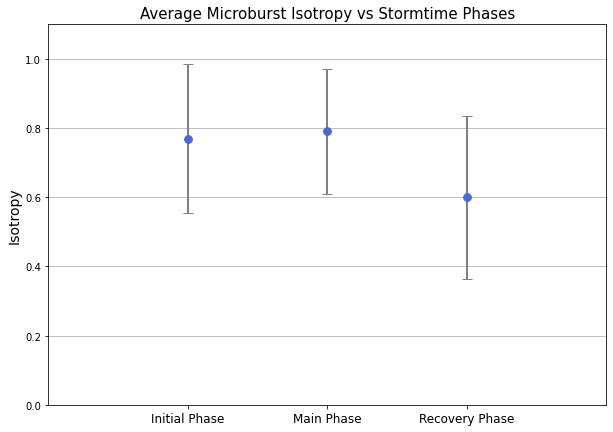

In [20]:
labels = np.array(['Initial Phase', 'Main Phase', 'Recovery Phase'])
labels_x = np.array([1.0,2.0,3.0])

iso_MB_avgs = np.array([np.nanmean(iso_MB_prestorm_list), np.nanmean(iso_MB_mainphase_list), np.nanmean(iso_MB_recovery_list)])
iso_MB_std = np.array([np.nanstd(iso_MB_prestorm_list), np.nanstd(iso_MB_mainphase_list), np.nanstd(iso_MB_recovery_list)])

plt.figure(figsize = (10,7))
plt.title(f'Average Microburst Isotropy vs Stormtime Phases', fontsize = 15)
plt.scatter(labels_x, iso_MB_avgs, c='royalblue', s = 60, zorder=3)
plt.errorbar(labels_x, iso_MB_avgs, yerr = iso_MB_std, fmt='none', elinewidth = 2.0, capsize=5, ecolor = 'grey', zorder=2)
plt.xlim(0, np.max(labels_x)+1.0)
plt.xticks(ticks=labels_x, labels=labels, fontsize=12)
plt.ylim(0,1.1)
plt.ylabel('Isotropy', fontsize=14)
plt.grid(axis='y')

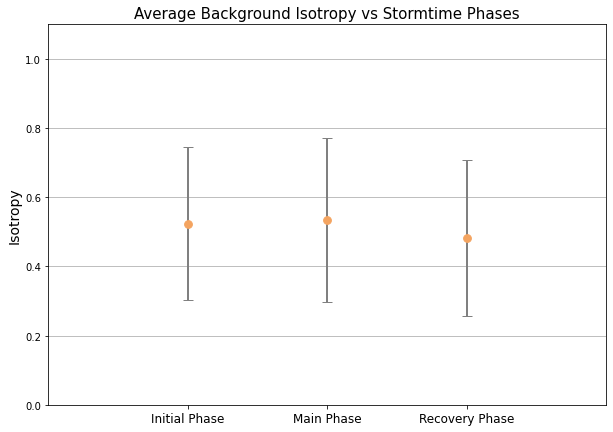

In [21]:
labels = np.array(['Initial Phase', 'Main Phase', 'Recovery Phase'])
labels_x = np.array([1.0,2.0,3.0])

iso_BG_avgs = np.array([np.nanmean(iso_BG_prestorm_list), np.nanmean(iso_BG_mainphase_list), np.nanmean(iso_BG_recovery_list)])
iso_BG_std = np.array([np.nanstd(iso_BG_prestorm_list), np.nanstd(iso_BG_mainphase_list), np.nanstd(iso_BG_recovery_list)])

plt.figure(figsize = (10,7))
plt.title(f'Average Background Isotropy vs Stormtime Phases', fontsize = 15)
plt.scatter(x, iso_BG_avgs, c='sandybrown', s = 60, zorder=3)
plt.errorbar(x, iso_BG_avgs, yerr = iso_BG_std, fmt='none', elinewidth = 2.0, capsize=5, ecolor = 'grey', zorder=2)
plt.xlim(0, np.max(labels_x)+1)
plt.xticks(ticks=x, labels=labels, fontsize=12)
plt.ylim(0,1.1)
plt.ylabel('Isotropy', fontsize=14)
plt.grid(axis='y')

In [19]:
print(iso_BG_std)

[0.22168347 0.23678312 0.22593524]
